# Installing libraries

In [1]:
! pip install reportlab
! pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 11.2 MB/s eta 0:00:00


# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding, Dropout
from tensorflow.keras.models import Model
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors

2024-05-12 11:32:42.790271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 11:32:42.790369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 11:32:42.935110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Stopping words

In [3]:
stop_words = set(stopwords.words('english'))

# Function to load the data

In [4]:
def load_data():
    # Load data from a CSV file using pandas. The specific parameters are:
    # - The file path '../input/sentiment140/training.1600000.processed.noemoticon.csv'
    # - The encoding type 'ISO-8859-1' to correctly interpret the file's character encoding
    # - 'header=None' indicates that the first line in the file is not a header row,
    #   which means pandas will automatically assign integer labels to the columns
    df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)

    # Print the column labels of the DataFrame. Since 'header=None', it will show default integer indices.
    print(df.columns)

    # Print the first five rows of the DataFrame to get a preview of the data.
    print(df.head())

    # Return the loaded DataFrame to the caller
    return df

# Function to extract the text sentences from the data

In [5]:
def extract_data(df):
    # Drop specific columns from the DataFrame
    # Columns with indices 1, 2, 3, and 4 are removed from the DataFrame.
    # `axis=1` specifies that columns should be dropped (not rows),
    # `inplace=True` means the original DataFrame is modified directly.
    df.drop([1, 2, 3, 4], axis=1, inplace=True)

    # Rename the remaining columns of the DataFrame
    # The first column is named 'sentiment' and the second is named 'data'.
    # This assumes that after dropping the columns, two columns remain.
    df.columns = ['sentiment', 'data']

    # Print a message to indicate the stage of processing
    print("\nData after removing unnecessary columns: \n")

    # Print the first five rows of the DataFrame to show a preview of the modified data.
    print(df.head())

    # Return the modified DataFrame to the caller
    return df

# Function to clean each sentence

In [6]:
def clean_text(sentence):
    # Removing URLS
    sentence = re.sub(r"https?://\S+|www\.\S+"," ",sentence)
    
    # Removing html tags
    sentence = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"," ",sentence)
    
    # Removing the Punctuation
    sentence = re.sub(r"[^\w\s]", " ", sentence)
        
    # Removing words that have numbers 
    sentence = re.sub(r"\w*\d\w*", " ", sentence)
        
    # Removing Digits 
    sentence = re.sub(r"[0-9]+", " ", sentence)
        
    # Cleaning white spaces
    sentence = re.sub(r"\s+", " ", sentence).strip()
        
    sentence = sentence.lower()
    # Check stop words
    tokens = []
    for token in sentence.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens) 

# Function to change the label of Negative from 4 to 1

In [7]:
def change_label_value(df):
    # Extract the 'sentiment' column from the DataFrame and convert it to a NumPy array
    y = df['sentiment'].values

    # Replace values of 4 in the 'sentiment' column with 1
    y[y == 4] = 1

    # Return the modified NumPy array
    return y

# Function to split the data to train and test

In [8]:
def split_data(df, y):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.3, random_state=42)

    # Print the shapes of the training and testing sets
    print('\nTrain Shape: ', X_train.shape)
    print('Test Shape: ', X_test.shape)
    print('Y Train Shape: ', y_train.shape)
    print('Y Test Shape: ', y_test.shape)
    print("\n")

    # Return the split data as separate variables
    return X_train, X_test, y_train, y_test

# Function to clean the sentences and tokenize them

In [9]:
def tokenize_data(X_train, X_test, max_words):
    # Initialize a tokenizer object with a specified maximum number of words.
    # `max_words` limits the tokenizer to use only the top `max_words` most frequent words in the dataset.
    tokenizer = Tokenizer(num_words=max_words)

    # Fit the tokenizer on the training data
    # This step builds the word index and learns about the frequencies of various words.
    tokenizer.fit_on_texts(X_train)

    # Convert the training texts to sequences of integers
    # Each word in the text is replaced by its corresponding integer value from the tokenizer's word index.
    sequence_X_train = tokenizer.texts_to_sequences(X_train)

    # Convert the testing texts to sequences of integers using the same tokenizer
    # This ensures consistency in how words are represented between training and testing datasets.
    sequence_X_test = tokenizer.texts_to_sequences(X_test)

    # Return the tokenized data and the tokenizer itself
    # Returning the tokenizer is useful for encoding additional texts using the same word index,
    # such as during deployment or further validation tests.
    return sequence_X_train, sequence_X_test, tokenizer

# Function to the Vocab length

In [10]:
def get_vocab_length(tokenizer):

    # Get the vocabulary dictionary from the tokenizer
    vocab = tokenizer.word_index

    # Calculate the length of the vocabulary
    vocab_length = len(vocab)

    # Print the number of independent tokens in the dataset
    print('dataset has %s number of independent tokens' % vocab_length)

    # Print a blank line for clarity
    print("\n")

    # Return the vocabulary length
    return vocab_length

# Function to pad shorter sequences to make the length of all sequences the same

In [11]:
def pad_data(sequence_X_train, sequence_X_test):
    """
    Pads the input sequence data for consistency.

    Args:
        sequence_X_train (np.ndarray): Training sequence data.
        sequence_X_test (np.ndarray): Testing sequence data.

    Returns:
        tuple: A tuple containing padded training and testing sequences.
    """

    # Pad the training data.
    padded_X_train = pad_sequences(sequence_X_train)

    # Get the maximum length across all sequences.
    maxlen = padded_X_train.shape[1]

    # Pad the testing data.
    padded_X_test = pad_sequences(sequence_X_test, maxlen=maxlen)

    # Print the shapes of the padded data.
    print(f"Shapes of training and testing data after padding:\nTraining data: {padded_X_train.shape}\nTesting data: {padded_X_test.shape}\n")

    # Return the padded data.
    return padded_X_train, padded_X_test, maxlen

# Function to plot the each model architecture

In [12]:
def plot_model(model, model_number):

    # Plot the model architecture using plot_model function from Keras
    tf.keras.utils.plot_model(model, to_file=f'model_plot{model_number}.png', show_shapes=True, show_layer_names=True)
    
    # Load the image generated by plot_model function
    img = mpimg.imread(f'/kaggle/working/model_plot{model_number}.png')
    
    # Set the figure size (width, height) in inches for the plot
    plt.figure(figsize=(11, 15))  

    # Plot the image without axis labels
    plt.imshow(img)
    plt.axis('off')  
    plt.show()

# Function to plot the history of each model

In [13]:
def plot_history(history, save_path=None):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    plt.show()


# Function to build each model architecture

In [14]:
def build_model(model_number, model_parameters, maxlen, vocab_length, d=20, window=3, pow=5):

    # Define the input layer
    i = Input((maxlen,))
    
    # Add an embedding layer
    x = Embedding(vocab_length+1, d)(i)
    
    # Add a Conv1D layer with specified parameters
    x = Conv1D(2 ** pow, window, activation='relu')(x)
    
    # Add a MaxPooling1D layer
    x = MaxPooling1D(3)(x)
    
    # Add a Dropout layer for regularization
    x = Dropout(0.5)(x)
    
    # Add another Conv1D layer with different parameters
    x = Conv1D(2 ** (1 + pow), window, activation='relu')(x)
    
    # Add another MaxPooling1D layer
    x = MaxPooling1D(3)(x)
    
    # Add a third Conv1D layer with different parameters
    x = Conv1D(2 ** (2 + pow), window, activation='relu')(x)
    
    # Add a GlobalMaxPooling1D layer to aggregate the features
    x = GlobalMaxPooling1D()(x)
    
    # Add a Dropout layer for regularization
    x = Dropout(0.5)(x)
    
    # Add a Dense layer with sigmoid activation for binary classification
    x = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(i, x)

    # Compile the model with binary cross-entropy loss and Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Save the model parameters for future reference
    model_parameters[model_number] = [d, window, 2**pow, 2 ** (1 + pow), 2 ** (2 + pow)]

    # Print the model details
    print(f"\nModel{model_number}")
    print(f"Model Parameters: Embedding dimension = {model_parameters[model_number][0]}, Window = {model_parameters[model_number][1]}, 1- Conv1D no. filters = {model_parameters[model_number][2]}, 2- Conv1D no. filters = {model_parameters[model_number][3]} 3- Conv1D no. filters = {model_parameters[model_number][4]}\n")

    # Plot the model architecture
    plot_model(model, model_number)

    # Return the model
    return model

# Function to fit each model on the data

In [15]:
def fit_models(models, padded_sequences_train, y_train, padded_sequences_test, y_test):
    
    best_model = None
    best_acc = 0

    # Iterate over each model in the list of models
    for i, model in enumerate(models):
        
        # Print the model number for clarity
        print(f"\nModel{i+1}:")
        
        # Fit the model on the training data and evaluate on the testing data
        history = model.fit(padded_sequences_train, y_train, validation_data=(padded_sequences_test, y_test), epochs=4, batch_size=64)
        
        # Print a blank line for clarity
        print("\n")

        # Plot the training and validation history for the current model
        plot_history(history, save_path=f"Model_history_{i+1}.png")
        model_test_acc = model.evaluate(padded_sequences_test, y_test)[1]
        if model_test_acc > best_acc:
            best_acc = model_test_acc
            best_model = model
    return best_model

# Function to generate a PDF containing the results and used architectures

In [16]:
def generate_results_pdf(model_parameters, y_samples, y_predict):
    # Create a PDF document
    doc = SimpleDocTemplate("Results.pdf", pagesize=letter)

    # Define the styles for the document
    styles = getSampleStyleSheet()

    # Create a list to store the PDF components
    pdf_components = []

    # Iterate over each model parameter in the dictionary
    for i, model_parameter in model_parameters.items():
        
        # Create a heading for the model
        heading1 = Paragraph(f"Model {i}:", styles["Heading1"])
        
        # Create a paragraph with the model parameters
        text = f"Parameters: Embedding dimension = {model_parameter[0]}, Window = {model_parameter[1]}, 1- Conv1D no. filters = {model_parameter[2]}, 2- Conv1D no. filters = {model_parameter[3]} 3- Conv1D no. filters = {model_parameter[4]}"
        para1 = Paragraph(text, styles["Normal"])
        
        # Load and add the model plot image to the PDF components
        img = Image(f"/kaggle/working/model_plot{i}.png", width=400, height=600)
        pdf_components += [heading1] + [Spacer(1, 20)] + [para1] + [Spacer(1, 20)] + [img]

        # Load and add the model history plot image to the PDF components
        acc = Image(f"/kaggle/working/Model_history_{i}.png", width=300, height=300)
        
        pdf_components += [Spacer(1, 20)] + [acc] + [Spacer(1, 20)] 
        
    # Create a heading for the sample predictions
    heading2 = Paragraph("Truth labels and predicted labels of 10 randomly selected samples based on the best model:", styles["Heading2"])
    pdf_components += [heading2, Spacer(1, 20)]

    # Create data for the table (including the headers)
    data = [["Sample Index", "True Label", "Predicted Label"]] + \
           [[f"Sample {index+1}", y_sample, y_pred] for index, (y_sample, y_pred) in enumerate(zip(y_samples, y_predict))]

    # Create the table with the data
    table = Table(data)
    
    # Add style to the table
    table_style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
        ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ])
    table.setStyle(table_style)
    
    pdf_components += [table, Spacer(1, 20)]

    # Create a heading for the Conclusion
    heading3 = Paragraph("Conclusion:", styles["Heading2"])
    pdf_components += [heading3, Spacer(1, 20)]

    # Conclusion paragraph
    para3 = Paragraph("According to the accuracies of each architecture, it appears that the first one outperforms the others as its simplicity of using just embedding vectors of length 20 and kernel width of 3 cause it to generalize well on the data.", styles["Normal"])
    pdf_components += [para3, Spacer(1, 20)]

    # Build the PDF document with the components
    doc.build(pdf_components)

# Function to evaluate model on random samples

In [17]:
def evaluate_model_randomly(model, padded_X_test, y_test):
    # Choose 10 random indices
    random_indices = np.random.choice(len(padded_X_test), size=10, replace=False)
    
    # Select samples
    X_samples = padded_X_test[random_indices]
    y_samples = y_test[random_indices]
    
    # Make predictions
    y_predict = (model.predict(X_samples).reshape(-1,) > 0.5) * 1
    
    print("Truth labels and predicted labels of the best model: ")
    print(y_samples, y_predict)
    
    return y_samples, y_predict

# Function to run the whole program

In [18]:
def run():
    # Load the data
    df = load_data()

    # Extract the data from the loaded dataframe
    df = extract_data(df)
    
    # Clean the data
    df.loc[:, 'data'] = df['data'].apply(clean_text)

    # Convert the labels to numerical values
    y = change_label_value(df)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = split_data(df, y)

    # Clean and tokenize the text data
    sequence_X_train, sequence_X_test, tokenizer = tokenize_data(X_train, X_test, 25000)

    # Get the vocabulary length
    vocab_length = get_vocab_length(tokenizer)

    # Pad the sequences to have the same length
    padded_X_train, padded_X_test, maxlen = pad_data(sequence_X_train, sequence_X_test)

    # Build and train the models
    model_parameters = {}
    models = [
        build_model(1, model_parameters, maxlen, vocab_length, d=20, window=3, pow=5),
        build_model(2, model_parameters, maxlen, vocab_length, d=40, window=4, pow=5),
        build_model(3, model_parameters, maxlen, vocab_length, d=40, window=5, pow=6),
        build_model(4, model_parameters, maxlen, vocab_length, d=20, window=5, pow=6)
    ]
    best_model = fit_models(models, padded_X_train, y_train, padded_X_test, y_test)
    
    y_samples, y_predict = evaluate_model_randomly(best_model, padded_X_test, y_test)

    # Generate the results PDF
    generate_results_pdf(model_parameters, y_samples, y_predict)

Index([0, 1, 2, 3, 4, 5], dtype='int64')
   0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....  

Data after removing unnecessary columns: 

   sentiment                                               data
0          0  @switchfoot http://twitpic.com/2y1zl - Awww,

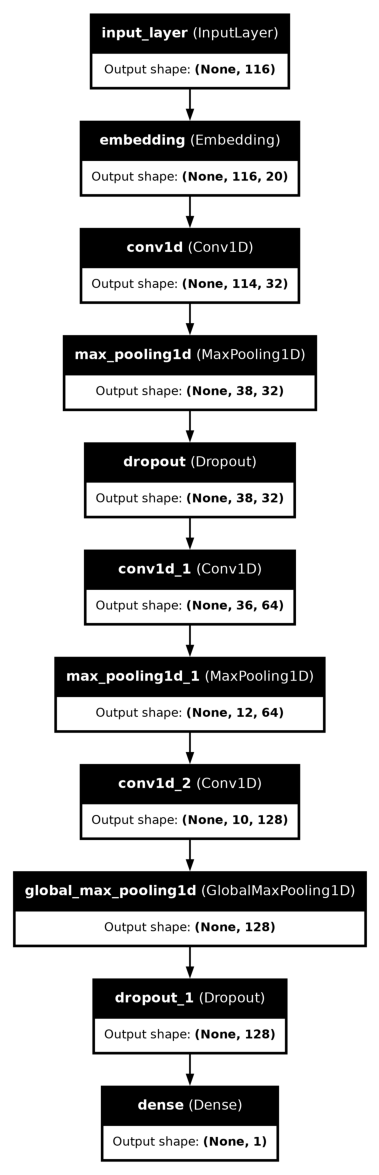


Model2
Model Parameters: Embedding dimension = 40, Window = 4, 1- Conv1D no. filters = 32, 2- Conv1D no. filters = 64 3- Conv1D no. filters = 128



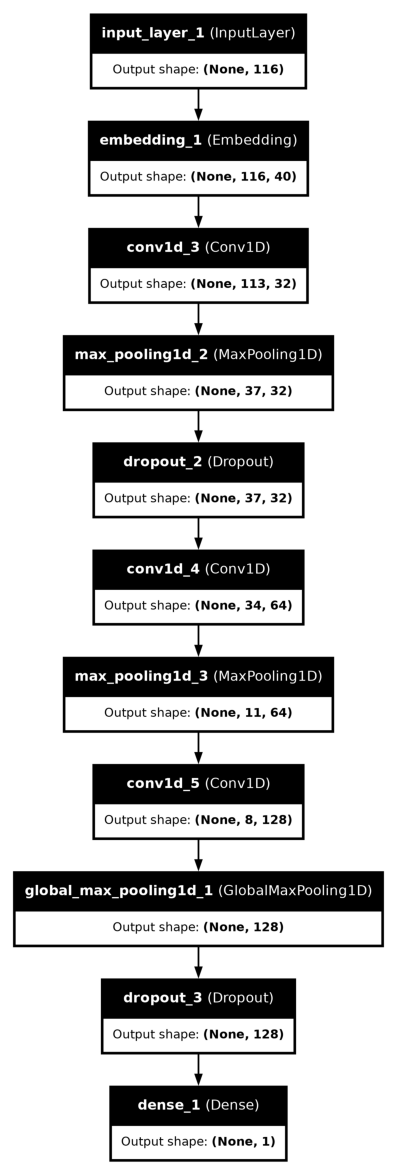


Model3
Model Parameters: Embedding dimension = 40, Window = 5, 1- Conv1D no. filters = 64, 2- Conv1D no. filters = 128 3- Conv1D no. filters = 256



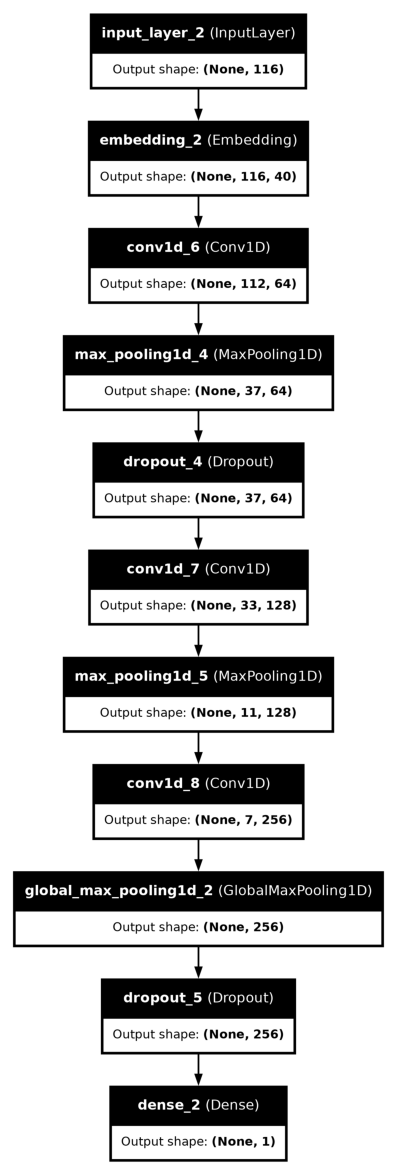


Model4
Model Parameters: Embedding dimension = 20, Window = 5, 1- Conv1D no. filters = 64, 2- Conv1D no. filters = 128 3- Conv1D no. filters = 256



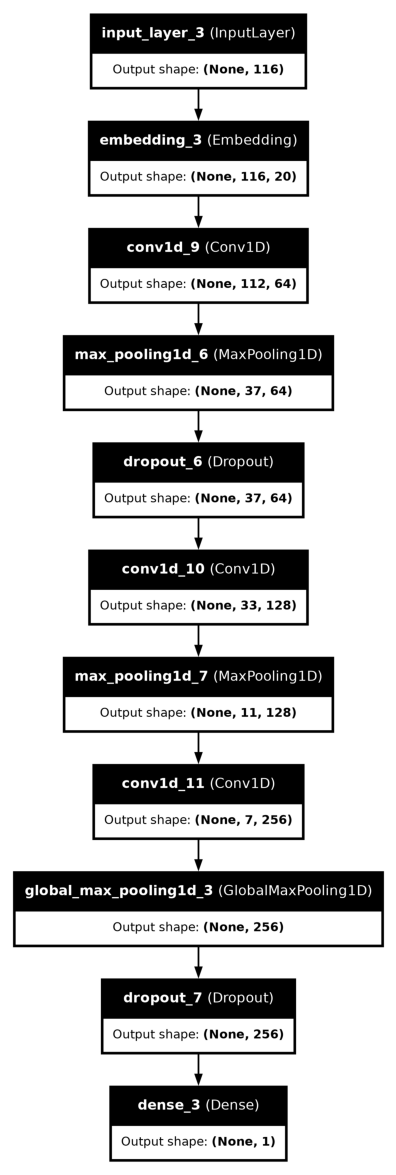


Model1:
Epoch 1/4
   45/17500 ━━━━━━━━━━━━━━━━━━━━ 1:02 4ms/step - accuracy: 0.5042 - loss: 0.6942

I0000 00:00:1715513708.889835     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17500/17500 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.7395 - loss: 0.5192 - val_accuracy: 0.7784 - val_loss: 0.5028
Epoch 2/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 76s 4ms/step - accuracy: 0.7845 - loss: 0.4604 - val_accuracy: 0.7802 - val_loss: 0.5027
Epoch 3/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7921 - loss: 0.4469 - val_accuracy: 0.7833 - val_loss: 0.4820
Epoch 4/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.7988 - loss: 0.4361 - val_accuracy: 0.7795 - val_loss: 0.4993




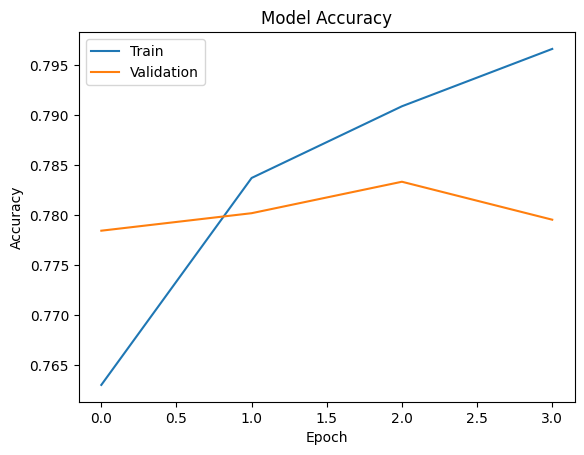

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - accuracy: 0.7791 - loss: 0.4991

Model2:
Epoch 1/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.5832 - loss: 0.6587 - val_accuracy: 0.6031 - val_loss: 0.6500
Epoch 2/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - accuracy: 0.6095 - loss: 0.6376 - val_accuracy: 0.6044 - val_loss: 0.6453
Epoch 3/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - accuracy: 0.6172 - loss: 0.6288 - val_accuracy: 0.6018 - val_loss: 0.6520
Epoch 4/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - accuracy: 0.6226 - loss: 0.6216 - val_accuracy: 0.6015 - val_loss: 0.6483




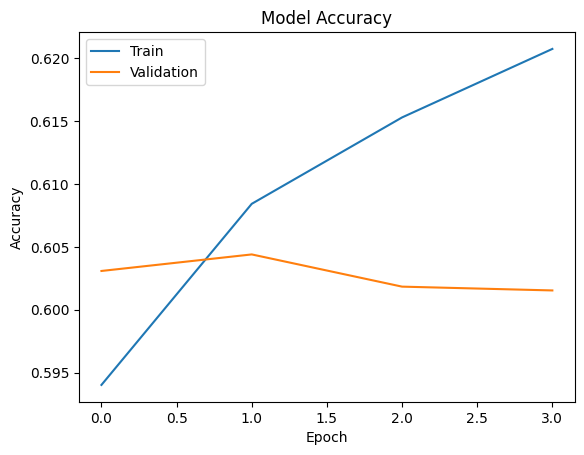

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.6011 - loss: 0.6477

Model3:
Epoch 1/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 111s 6ms/step - accuracy: 0.7114 - loss: 0.5545 - val_accuracy: 0.7399 - val_loss: 0.5267
Epoch 2/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 105s 6ms/step - accuracy: 0.7486 - loss: 0.5081 - val_accuracy: 0.7427 - val_loss: 0.5312
Epoch 3/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 104s 6ms/step - accuracy: 0.7585 - loss: 0.4918 - val_accuracy: 0.7430 - val_loss: 0.5223
Epoch 4/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 104s 6ms/step - accuracy: 0.7678 - loss: 0.4775 - val_accuracy: 0.7413 - val_loss: 0.5255




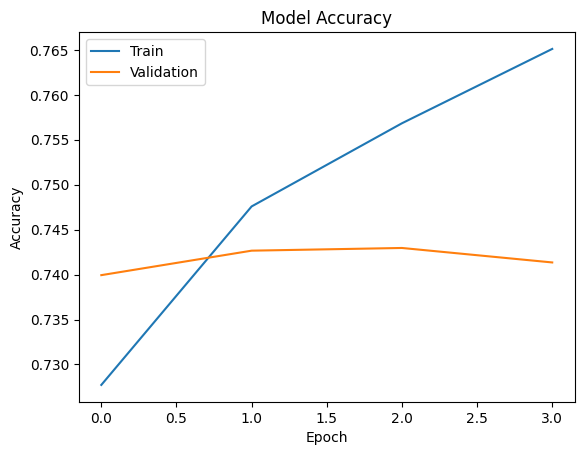

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.7414 - loss: 0.5253

Model4:
Epoch 1/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 87s 5ms/step - accuracy: 0.7072 - loss: 0.5573 - val_accuracy: 0.7405 - val_loss: 0.5288
Epoch 2/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.7480 - loss: 0.5091 - val_accuracy: 0.7422 - val_loss: 0.5287
Epoch 3/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.7577 - loss: 0.4936 - val_accuracy: 0.7429 - val_loss: 0.5329
Epoch 4/4
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - accuracy: 0.7647 - loss: 0.4821 - val_accuracy: 0.7383 - val_loss: 0.5329




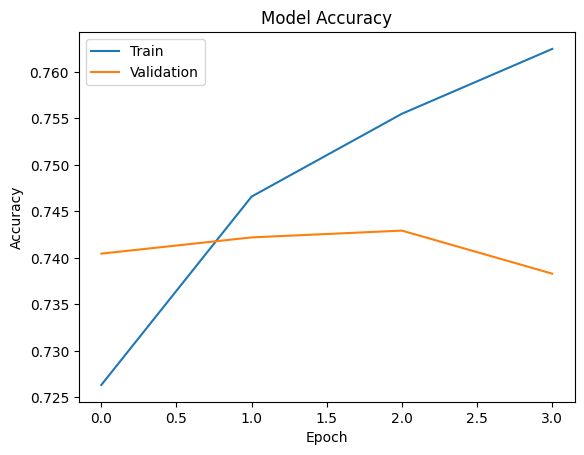

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.7382 - loss: 0.5326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
Truth labels and predicted labels of the best model: 
[1 0 0 0 0 0 0 0 0 0] [1 0 0 0 0 1 0 0 0 0]


In [19]:
# Calling the run function
run()